In [3]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 725.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 135.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.1 MB/s eta 0:00:00


In [4]:
import re, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [5]:
# 4️⃣ Load CSVs
# =========================
df_train = pd.read_csv("/content/sentimix_train.csv")
df_val   = pd.read_csv("/content/sentimix_val.csv")
df_test  = pd.read_csv("/content/sentimix_test.csv")

In [7]:
# Print shapes
print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)
print("Test shape:", df_test.shape)

Train shape: (14000, 5)
Validation shape: (3000, 5)
Test shape: (3000, 13)


In [9]:
# Regex patterns for cleaning
URL_REGEX = re.compile(r"https?://\S+|www\.\S+")
MENTION_REGEX = re.compile(r"@\w+")
HASHTAG_REGEX = re.compile(r"#\w+")
REPEAT_CHAR = re.compile(r"(.)\1{2,}")

# Cleaning function
def clean_text(text):
    if pd.isna(text): return ""
    text = str(text).lower()
    text = URL_REGEX.sub(" ", text)
    text = MENTION_REGEX.sub(" ", text)
    text = HASHTAG_REGEX.sub(lambda m: m.group(0)[1:], text)
    text = REPEAT_CHAR.sub(r"\1\1", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return " ".join(text.split())

# Apply cleaning to 'tweet' column
df_train['text_clean'] = df_train['tweet'].apply(clean_text)
df_val['text_clean']   = df_val['tweet'].apply(clean_text)
df_test['text_clean']  = df_test['tweet'].apply(clean_text)

# Check sample
df_train[['tweet', 'text_clean']].head()


,tweet,text_clean
0,nen á vist bolest vztek smutek zmatek osam ě l...,nen á vist bolest vztek smutek zmatek osam ě l...
1,@nehantics Haan yaar neha 😔😔 kab karega woh po...,haan yaar neha 😔😔 kab karega woh post 😭usne na...
2,@RahulGandhi television media congress ke liye...,television media congress ke liye nhi hye toh ...
3,@AmitShah @narendramodi All India me nrc lagu ...,all india me nrc lagu kare w kashmir se dhara ...
4,@Nehr _ who @TypoMantri @anjanaomkashyap Pagal...,who pagal hai kya they aren ’ t real issues ma...


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 100
VOCAB_SIZE = 20000

# Fit tokenizer on training data only
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<UNK>")
tokenizer.fit_on_texts(df_train['text_clean'])

# Convert texts to sequences
X_train = tokenizer.texts_to_sequences(df_train['text_clean'])
X_val   = tokenizer.texts_to_sequences(df_val['text_clean'])
X_test  = tokenizer.texts_to_sequences(df_test['text_clean'])

# Pad sequences
X_train = pad_sequences(X_train, maxlen=MAX_LEN, padding="post")
X_val   = pad_sequences(X_val, maxlen=MAX_LEN, padding="post")
X_test  = pad_sequences(X_test, maxlen=MAX_LEN, padding="post")

print("Tokenization and padding done!")


Tokenization and padding done!


In [11]:
import tensorflow as tf

# Get sorted unique labels from training data
labels = sorted(df_train['sentiment'].unique())
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}

# Map labels to integers
y_train = df_train['sentiment'].map(label2id).values
y_val   = df_val['sentiment'].map(label2id).values
y_test  = df_test['sentiment'].map(label2id).values

# Convert to categorical (one-hot)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(labels))
y_val   = tf.keras.utils.to_categorical(y_val, num_classes=len(labels))
y_test  = tf.keras.utils.to_categorical(y_test, num_classes=len(labels))

print("Classes:", label2id)


Classes: {'negative': 0, 'neutral': 1, 'positive': 2}


In [12]:
from tensorflow.keras import layers, models

model_bilstm = models.Sequential([
    layers.Embedding(VOCAB_SIZE, 128, input_length=MAX_LEN),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(labels), activation="softmax")
])

model_bilstm.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_bilstm.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=64
)


Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.3787 - loss: 1.0868 - val_accuracy: 0.4763 - val_loss: 0.9832
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.4937 - loss: 0.9549 - val_accuracy: 0.4997 - val_loss: 0.9315
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.5734 - loss: 0.8636 - val_accuracy: 0.5733 - val_loss: 0.8836
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.6958 - loss: 0.7097 - val_accuracy: 0.5863 - val_loss: 0.9173
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.7925 - loss: 0.5514 - val_accuracy: 0.5883 - val_loss: 1.0592


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Validation Classification Report:
              precision    recall  f1-score   support

    negative       0.62      0.61      0.61       890
     neutral       0.51      0.51      0.51      1128
    positive       0.65      0.66      0.65       982

    accuracy                           0.59      3000
   macro avg       0.59      0.59      0.59      3000
weighted avg       0.59      0.59      0.59      3000



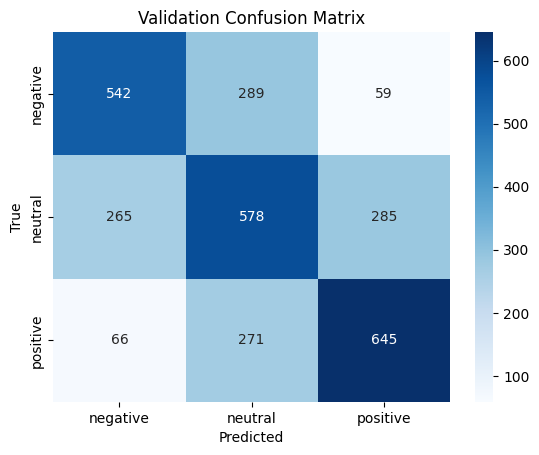

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Test Classification Report:
              precision    recall  f1-score   support

    negative       0.65      0.65      0.65       900
     neutral       0.51      0.55      0.53      1100
    positive       0.72      0.67      0.69      1000

    accuracy                           0.62      3000
   macro avg       0.63      0.62      0.63      3000
weighted avg       0.62      0.62      0.62      3000



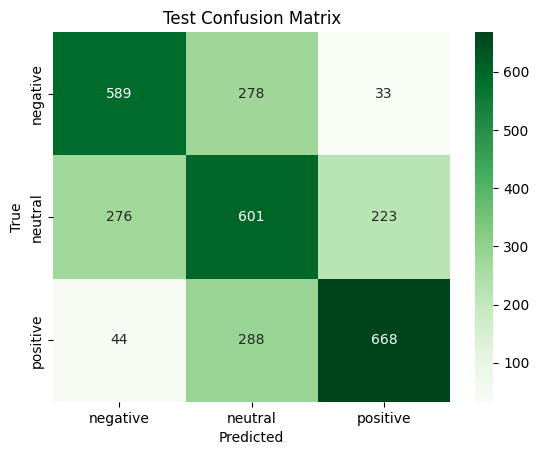

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Validation Set ---
y_pred_val = model_bilstm.predict(X_val)
y_pred_classes_val = np.argmax(y_pred_val, axis=1)
y_true_val = np.argmax(y_val, axis=1)

print("Validation Classification Report:")
print(classification_report(y_true_val, y_pred_classes_val, target_names=labels))

cm_val = confusion_matrix(y_true_val, y_pred_classes_val)
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Validation Confusion Matrix")
plt.show()

# --- Test Set ---
y_pred_test = model_bilstm.predict(X_test)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_true_test = np.argmax(y_test, axis=1)

print("Test Classification Report:")
print(classification_report(y_true_test, y_pred_classes_test, target_names=labels))

cm_test = confusion_matrix(y_true_test, y_pred_classes_test)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix")
plt.show()


In [16]:
# 1️⃣ Clean the text (same as training)
def clean_input(text):
    text = str(text).lower()
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"#\w+", lambda m: m.group(0)[1:], text)
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return " ".join(text.split())

In [17]:
new_texts = [
    "Yaar aaj mood bohot kharab hai 😞",
    "Party mast thi kal, full enjoy kiya!",
    "@friend tu bohot help kar raha hai, thanks!"
]

In [18]:
new_texts_clean = [clean_input(t) for t in new_texts]

# 2️⃣ Tokenize & pad
new_seq = tokenizer.texts_to_sequences(new_texts_clean)
new_pad = pad_sequences(new_seq, maxlen=MAX_LEN, padding="post")

# 3️⃣ Predict
pred_probs = model_bilstm.predict(new_pad)
pred_classes = np.argmax(pred_probs, axis=1)
pred_labels = [id2label[c] for c in pred_classes]

# 4️⃣ Show results
for txt, label in zip(new_texts, pred_labels):
    print(f"Tweet: {txt}\nPredicted Sentiment: {label}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tweet: Yaar aaj mood bohot kharab hai 😞
Predicted Sentiment: neutral

Tweet: Party mast thi kal, full enjoy kiya!
Predicted Sentiment: positive

Tweet: @friend tu bohot help kar raha hai, thanks!
Predicted Sentiment: neutral

